# Evaluando la mejor ventana de predicción

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM

In [ ]:
model = keras.models.load_model('./drive/MyDrive/DatosInvestigacion/RSG_model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 75)                23100     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 23,176
Trainable params: 23,176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_input=22
n_features = 0

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')
df = df.between_time('08:00:00','17:00:00')
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]


In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]
df_test = df_test.between_time('08:00:00','17:00:00')

In [ ]:
RSG = df['SRGLOAVG1H'].values
RSG = np.reshape(RSG,(-1,1))
RSG_test = df_test['SRGLOAVG1H'].values
RSG_test = np.reshape(RSG_test,(-1,1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(RSG)
scaled_train = scaler.transform(RSG)
scaled_test = scaler.transform(RSG_test)

Predecir la hora siguiente

In [ ]:
predictions = []
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j]
  model_input = model_input.reshape((1, n_input, n_features+1))
  predictions.append(model.predict(model_input)[0])
predictions = np.ndarray.flatten(np.array(predictions))  
true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)
errorMSE = mean_squared_error(true_values,true_predictions)
errorMAE = mean_absolute_error(true_values,true_predictions)

In [ ]:
errorMAE

128.46700768610035

In [ ]:
errorMSE**(1/2)

164.04970448822036

Predecir más horas

In [ ]:
ventana=2

In [ ]:
test_predictions = []
true_values = []
first_eval_batch = scaled_test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features+1))

for i in range(ventana):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_values.append(RSG_test[n_input+i])

In [ ]:
true_predictions = scaler.inverse_transform(np.reshape(test_predictions,(-1,1)))

In [ ]:
RSG_test[n_input:n_input+ventana]

array([[376.],
       [700.]])

In [ ]:
true_values

[array([376.]), array([700.])]

In [ ]:
true_predictions

array([[583.85754],
       [587.4029 ]], dtype=float32)

Ahora recorre todo el conjunto de pruebas

In [ ]:
ventana=2

In [ ]:
predictions = []
true_values = []
for j in range(n_input,len(df_test)-ventana):
  first_eval_batch = scaled_test[j-n_input:j]
  current_batch = first_eval_batch.reshape((1, n_input, n_features+1))
  for i in range(ventana):
      current_pred = model.predict(current_batch)[0]
      # guardar la predicción
      predictions.append(current_pred) 
      # actualizar el lote para incluir ahora la predicción y soltar primer valor
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
      true_values.append(RSG_test[j+i])
true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))

In [ ]:
true_values[:5]

[array([376.]), array([700.]), array([700.]), array([665.]), array([665.])]

In [ ]:
true_predictions[:5]

array([[583.85754],
       [587.4029 ],
       [424.48642],
       [512.0769 ],
       [699.3955 ]], dtype=float32)

In [ ]:
errorMSE = mean_squared_error(true_values,true_predictions)
errorMAE = mean_absolute_error(true_values,true_predictions)

In [ ]:
errorMAE

144.68448880123893

In [ ]:
errorMSE**(1/2)

183.5461698469602

In [ ]:
resultados = []

In [ ]:
for ventana in range(31,33):
  predictions = []
  true_values = []
  print('Ventana:',ventana)
  for j in range(n_input,len(df_test)-ventana):
    first_eval_batch = scaled_test[j-n_input:j]
    current_batch = first_eval_batch.reshape((1, n_input, n_features+1))
    for i in range(ventana):
        current_pred = model.predict(current_batch)[0]
        # guardar la predicción
        predictions.append(current_pred) 
        # actualizar el lote para incluir ahora la predicción y soltar primer valor
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        true_values.append(RSG_test[j+i])
  true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
  errorMSE = mean_squared_error(true_values,true_predictions)
  errorMAE = mean_absolute_error(true_values,true_predictions)  
  resultados.append({
      'Ventana':ventana,
      'MAE':errorMAE,
      'MSE':errorMSE**(1/2)
  })
  print(resultados[-1:])

Ventana: 31
[{'Ventana': 31, 'MAE': 191.38712928653553, 'MSE': 241.6641313653061}]
Ventana: 32
[{'Ventana': 32, 'MAE': 191.91656063223633, 'MSE': 242.3379253775286}]


In [ ]:
resultados[:2]

[{'MAE': 191.38712928653553, 'MSE': 241.6641313653061, 'Ventana': 31},
 {'MAE': 191.91656063223633, 'MSE': 242.3379253775286, 'Ventana': 32}]

In [ ]:
resultados = pd.DataFrame(resultados)

In [ ]:
resultados.head()

,Ventana,MAE,MSE
0,31,191.387129,241.664131
1,32,191.916561,242.337925


In [ ]:
resultados_anteriores=pd.read_csv('./drive/MyDrive/DatosInvestigacion/resultados_prediccion.csv')

In [ ]:
resultados_anteriores

,Ventana,MAE,MSE
0,1,128.525358,164.102554
1,2,144.684489,183.546170
2,3,153.849718,195.036732
3,4,159.817385,202.413374
4,5,163.831378,207.319242
5,6,166.612613,210.694948
6,7,168.525955,213.022941
7,8,169.951643,214.714797
8,9,171.181020,216.142421
9,10,172.362544,217.572187


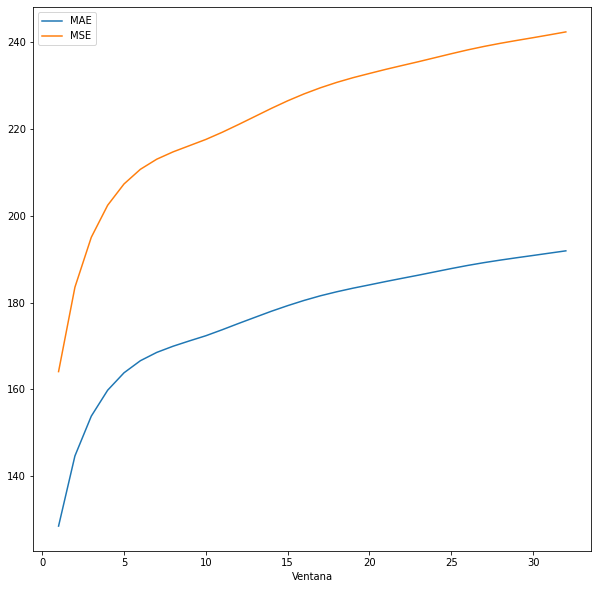

In [ ]:
resultados_anteriores.plot(x='Ventana',figsize=(10,10))

In [ ]:
resultados = pd.concat([resultados_anteriores,resultados],ignore_index=True)

In [ ]:
resultados

In [ ]:
resultados.to_csv('./drive/MyDrive/DatosInvestigacion/resultados_prediccion.csv',index=False)